In [222]:
from scipy.io import wavfile
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np
# import librosa as librosa
from hmmlearn import hmm
import os
from sklearn.model_selection import train_test_split
np.random.seed(1)

In [223]:
def load_audio_data(folder_path, num_recordings_per_digit=20):
    data = []
    labels = []


    for digit in range(10):
        digit_count = 0
        # maxlen = 0
        for filename in os.listdir(folder_path):
            if filename.endswith(".wav") and filename.startswith('digit'+str(digit)):
                file_path = os.path.join(folder_path, filename)

                _ , audio_data = wavfile.read(file_path)

                data.append(audio_data)
                labels.append(digit)

                digit_count += 1
                if digit_count == num_recordings_per_digit:
                    break

    return data, np.array(labels)

folder_path = './digitRecordings/'
audio_data, labels = load_audio_data(folder_path)

n_fft = 1024
noverlap  = 512
# n_mfcc = 13
for i in range(len(audio_data)):
    _,_,  audio_data[i] = stft(audio_data[i], nperseg=n_fft, noverlap=noverlap)
    audio_data[i] = 10*np.log(np.abs(audio_data[i]) + 1e-14)
    # audio_data[i] = librosa.feature.mfcc(audio_data[i].astype(float),sr = 10,n_me=n_mfcc)

print("Audio Data Shape:", len(audio_data))
print("Labels:", labels)


Audio Data Shape: 200
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [224]:
def pca(data): #takes input data as columns and expects it to be 0 mean (add mean back later if intended)
    covariance_matrix = np.dot(data,data.T)/(data.shape[1])
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:,::-1]

    return (eigvecs,eigvals)

#takes data with rows as features, columns as samples
def pcaReduce(data,n_components): #return eigvals and reduced data, and mean it subtracted 
    mean = np.mean(data,axis=1).reshape(-1,1)
    vecs, vals = pca(data - mean)
    PCAmat = vecs.T[:n_components]
    reduced = PCAmat @ (data - mean)
    return reduced,vals,mean, PCAmat

In [225]:
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=.25, stratify=labels)
sort_indices = np.argsort(y_train)

# Sort X_train and y_train by the labels
X_train = [X_train[i] for i in sort_indices]
y_train = y_train[sort_indices]

# Verify the shapes of the resulting sets
print("X_train_sorted shape:", len(X_train))
print("y_train_sorted shape:", y_train.shape)


X_train_sorted shape: 150
y_train_sorted shape: (150,)


In [226]:
nPCA = 5
reducedTrain,eigvals,PCAmean,PCAmat  = pcaReduce(np.hstack(X_train),nPCA)
temp  = []
startidx =0
for i in range(len(X_train)):
    temp.append(reducedTrain[:,startidx:startidx+X_train[i].shape[1]])
    startidx += X_train[i].shape[1]
reducedTrain=temp

In [227]:
def fitHmm(spectrogramList, n_states, n_gaussians):
    model = hmm.GMMHMM(n_components=n_states, n_mix=n_gaussians, covariance_type='diag')

    X = np.hstack(spectrogramList)

    lengths = [spec.shape[1] for spec in spectrogramList]
    X = X.T  

    model.fit(X, lengths=lengths)
    return model

def evaluatefromHmms(model_list, spectrogram):
    scores = np.zeros(len(model_list))
    for i in range(len(model_list)):
        scores[i], _ = model_list[i].decode(spectrogram.T)
    return np.argmax(np.exp(scores))

In [228]:
digitModels = []
n_states = 5
n_gaussians =1
for i in range(10):
    # print(i)
    digitModels.append(fitHmm(reducedTrain[i*15:(i+1)*15],n_states=n_states, n_gaussians=n_gaussians)) # 5 states 1 gaussian each


In [229]:
%%capture

trainConfMat = np.zeros((10,10))
testConfMat = np.zeros((10,10))

for i in range(len(X_train)):
    yhat = evaluatefromHmms(digitModels,PCAmat @(X_train[i] - PCAmean))
    y = y_train[i]
    trainConfMat[y,yhat] +=1

for i in range(len(X_test)):
    yhat = evaluatefromHmms(digitModels,PCAmat @(X_test[i] - PCAmean))
    y = y_test[i]
    testConfMat[y,yhat] +=1

Using 5  PCA components and  5 HMM states per model


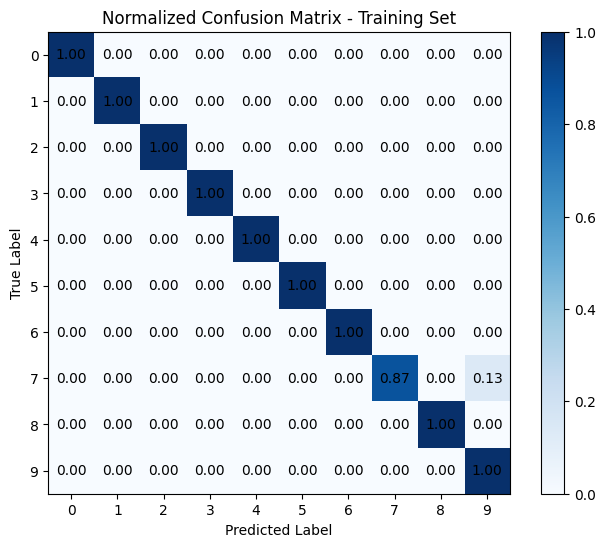

In [230]:
trainConfMatNormalized = trainConfMat.astype('float') / trainConfMat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
cax = plt.imshow(trainConfMatNormalized, cmap="Blues")
for i in range(trainConfMatNormalized.shape[0]):
    for j in range(trainConfMatNormalized.shape[1]):
        plt.text(j, i, f'{trainConfMatNormalized[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(np.arange(trainConfMatNormalized.shape[1]))
plt.yticks(np.arange(trainConfMatNormalized.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Training Set')

cbar = plt.colorbar(cax)
print("Using", PCAmat.shape[0], " PCA components and ", n_states, "HMM states per model")

plt.show()

Using 5  PCA components and  5 HMM states per model


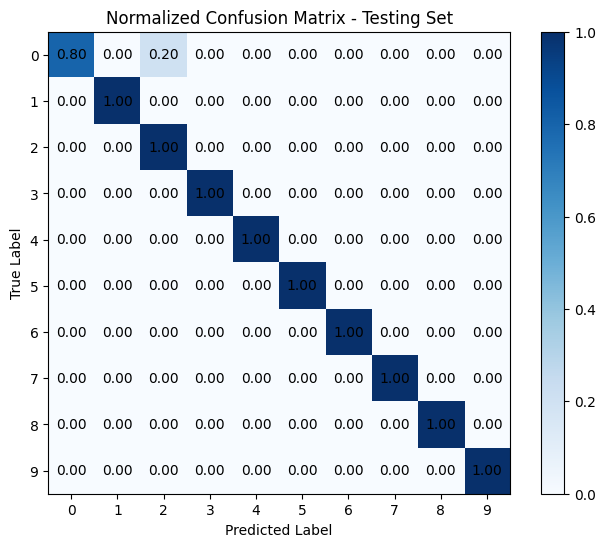

In [231]:
testConfMatNormalized = testConfMat.astype('float') / testConfMat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
cax = plt.imshow(testConfMatNormalized, cmap="Blues")
for i in range(testConfMatNormalized.shape[0]):
    for j in range(testConfMatNormalized.shape[1]):
        plt.text(j, i, f'{testConfMatNormalized[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(np.arange(testConfMatNormalized.shape[1]))
plt.yticks(np.arange(testConfMatNormalized.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix - Testing Set')

print("Using", PCAmat.shape[0], " PCA components and ", n_states, "HMM states per model")

cbar = plt.colorbar(cax)

plt.show()